In [5]:
# -----------------------------
# House Price Prediction - Kaggle Pipeline
# -----------------------------

# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [6]:
# -----------------------------
# Step 2: Load Train and Test Data
# -----------------------------
train = pd.read_csv(r"C:\Users\User\Desktop\My AI portfolio\house-price-prediction.py\data\raw\train.csv")
test = pd.read_csv(r"C:\Users\User\Desktop\My AI portfolio\house-price-prediction.py\data\raw\test.csv")
sample_submission = pd.read_csv(r"C:\Users\User\Desktop\My AI portfolio\house-price-prediction.py\data\raw\sample_submission.csv")

test_ids = test['Id']  # Save test IDs for submission

In [7]:
# -----------------------------
# Step 3: Data Preprocessing
# -----------------------------
columns_to_drop = ['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature']
train = train.drop(columns=columns_to_drop, axis=1)
test = test.drop(columns=columns_to_drop, axis=1)

In [8]:
# Fill missing categorical values with mode
categorical_cols = train.select_dtypes(include=['object']).columns
train[categorical_cols] = train[categorical_cols].fillna(train[categorical_cols].mode().iloc[0])
test[categorical_cols] = test[categorical_cols].fillna(train[categorical_cols].mode().iloc[0])

In [9]:
# Fill missing numerical values with median
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns.drop('SalePrice')
train[numerical_cols] = train[numerical_cols].fillna(train[numerical_cols].median())
test[numerical_cols] = test[numerical_cols].fillna(train[numerical_cols].median())

In [10]:
# One-hot encode categorical variables
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

In [11]:
# Align test columns to train columns
test = test.reindex(columns=train.drop('SalePrice', axis=1).columns, fill_value=0)

In [12]:
# -----------------------------
# Step 4: Split Features and Target
# -----------------------------
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# -----------------------------
# Step 5a: Linear Regression
# -----------------------------
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_valid)

mae_lin = mean_absolute_error(y_valid, y_pred_lin)
mse_lin = mean_squared_error(y_valid, y_pred_lin)
r2_lin = r2_score(y_valid, y_pred_lin)

In [14]:
# -----------------------------
# Step 5b: Random Forest Regressor
# -----------------------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_valid)

mae_rf = mean_absolute_error(y_valid, y_pred_rf)
mse_rf = mean_squared_error(y_valid, y_pred_rf)
r2_rf = r2_score(y_valid, y_pred_rf)

In [15]:
# -----------------------------
# Step 5c: Model Performance Comparison
# -----------------------------
metrics_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [mae_lin, mae_rf],
    "MSE": [mse_lin, mse_rf],
    "R²": [r2_lin, r2_rf]
}).round({'MAE': 2, 'MSE': 2, 'R²': 4})

print("Model Performance Comparison:")
print(metrics_df)

Model Performance Comparison:
               Model       MAE           MSE      R²
0  Linear Regression  20434.22  2.735172e+09  0.6434
1      Random Forest  17453.89  8.274981e+08  0.8921


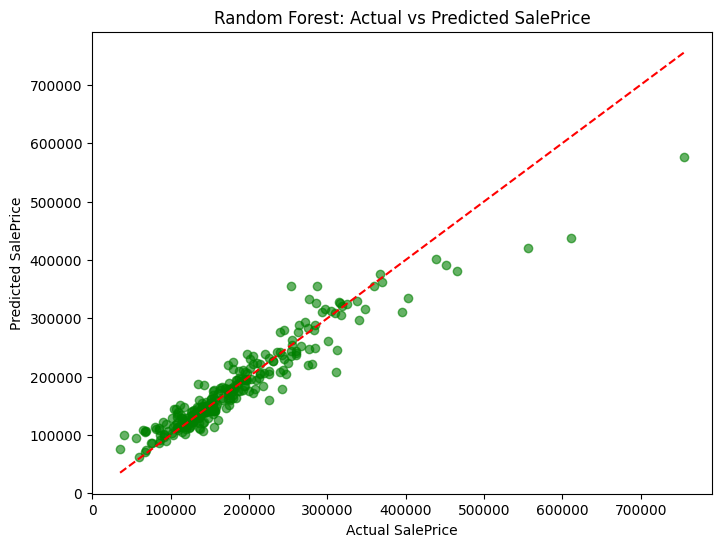

In [16]:
# -----------------------------
# Step 6: Visualizations
# -----------------------------

# 1️⃣ Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_valid, y_pred_rf, alpha=0.6, color='green')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Random Forest: Actual vs Predicted SalePrice")
plt.show()

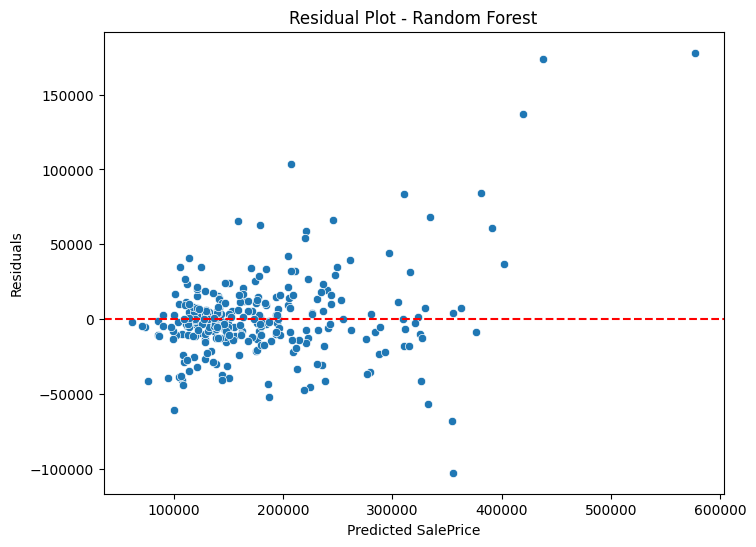

In [17]:
# 2️⃣ Residual Plot
residuals = y_valid - y_pred_rf
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred_rf, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.title("Residual Plot - Random Forest")
plt.show()

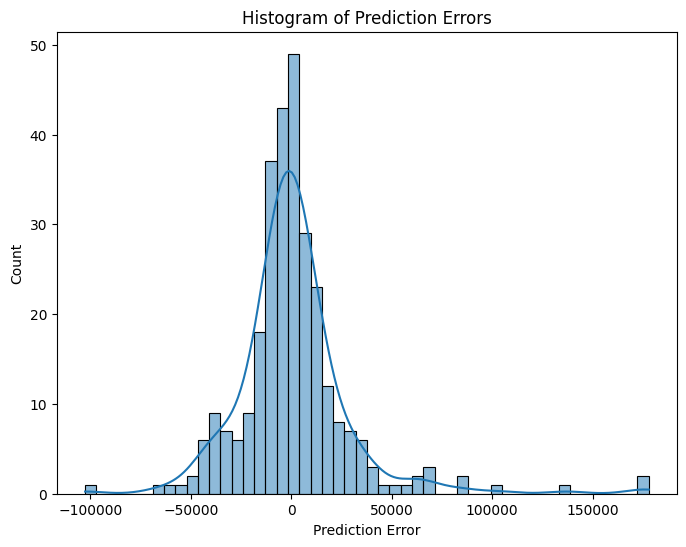

In [18]:
# 3️ Histogram of Prediction Errors
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Prediction Error")
plt.title("Histogram of Prediction Errors")
plt.show()

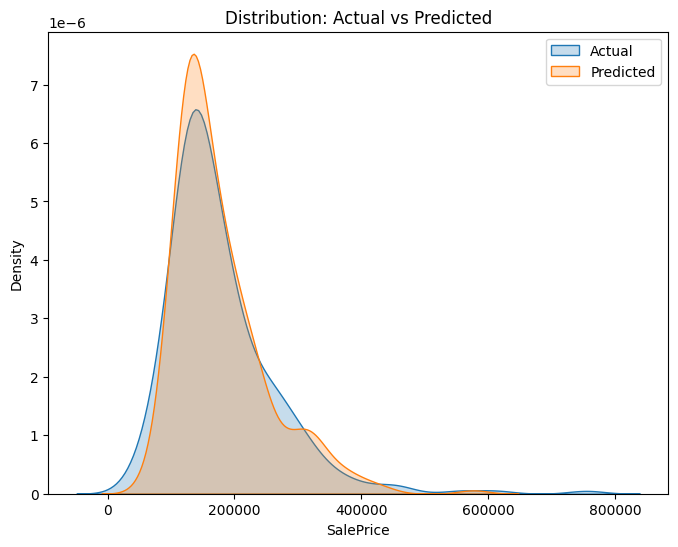

In [19]:
# 4️⃣ Distribution of Predicted vs Actual
plt.figure(figsize=(8,6))
sns.kdeplot(y_valid, label="Actual", fill=True)
sns.kdeplot(y_pred_rf, label="Predicted", fill=True)
plt.xlabel("SalePrice")
plt.title("Distribution: Actual vs Predicted")
plt.legend()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_21568\77207309.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(15), palette="viridis")


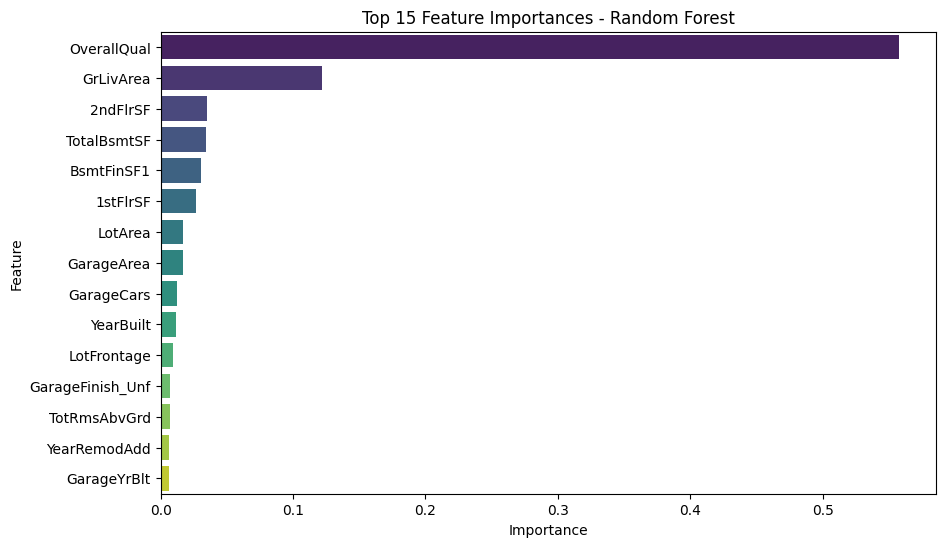

In [20]:
# 5️⃣ Feature Importance
feat_imp_df = pd.DataFrame({"Feature": X.columns, "Importance": rf_model.feature_importances_}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(15), palette="viridis")
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()

In [21]:
best_model = rf_model if r2_rf > r2_lin else lin_model

In [22]:
import joblib
from pathlib import Path

# Create directory
Path("artifacts").mkdir(exist_ok=True)

# Save model
joblib.dump(best_model, "artifacts/house_price_model.pkl")

# Save column order (VERY important for deployment)
joblib.dump(X_train.columns.tolist(), "artifacts/feature_columns.pkl")


['artifacts/feature_columns.pkl']

In [23]:
# -----------------------------
# Step 7: Predict on Test Set and Prepare Submission
# -----------------------------
predictions = rf_model.predict(test)
submission = pd.DataFrame({"Id": test_ids, "SalePrice": predictions})
submission.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
